In [5]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch.nn.functional as F
#@staticmethod
def unwarp_image(img, bm):
    assert bm.shape[3] == 2, "BM shape needs to be (N, H, W, C)"
    
    n, c, h, w = img.shape

    bm = bm.transpose(3, 2).transpose(2, 1)
    bm = F.interpolate(bm, size=(h, w), mode='bilinear', align_corners=True) # align_corners=True -> old behaviour
    bm = bm.transpose(1, 2).transpose(2, 3)

    bm = 2 * bm - 1 # adapt value range for grid_sample
    bm = bm.transpose(1, 2) # rotate image by 90 degrees (NOTE: this transformation might be deleted in future BM versions)
    
    img = img.float()
    res = F.grid_sample(input=img, grid=bm, align_corners=True) # align_corners=True -> old behaviour
    res = torch.clamp(res, 0, 1) # clip values because of numerical instabilities
    return res

In [3]:
import numpy as np

data_path = 'Dataset Preview/Inv3D preview complete V2/data/train/08'

img = cv2.imread(data_path + '/warped_document.png')
#img = dataset_train.transform_img(img)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)#.transpose(2,3).transpose
img = img / 255
print(img.shape)

torch.Size([1, 3, 256, 256])


In [8]:
warped_bm = np.load(data_path + '/warped_BM.npz')['warped_BM']
warped_bm = torch.from_numpy(warped_bm).float()
warped_bm = warped_bm.unsqueeze(0)
warped_bm.shape

torch.Size([1, 256, 256, 2])

In [10]:
images[1:2,:,:,:].shape

torch.Size([1, 3, 256, 256])

In [12]:
warped_bm = crease(images[1:2,:,:,:])

In [13]:
#model_bm.eval()
#warped_bm = model_bm(images[0-1,:,:,:].unsqueeze(0))
unwarped_img = unwarp_image(img, warped_bm.transpose(1,2).transpose(2,3))
unwarped_img =  unwarped_img.transpose(1,2).transpose(2,3)
unwarped_img.shape

torch.Size([1, 256, 256, 3])

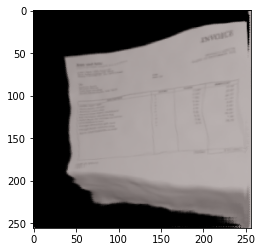

In [14]:
import matplotlib.pyplot as plt
plt.imshow(unwarped_img.detach().numpy()[0])

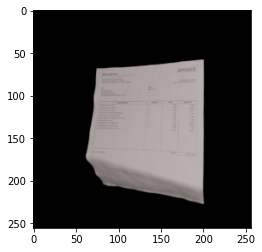

In [8]:
plt.imshow(img.transpose(1,2).transpose(2,3)[0])

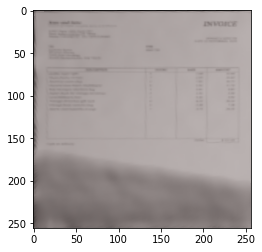

In [19]:
import matplotlib.pyplot as plt
plt.imshow(unwarped_img.numpy()[0])

In [3]:
import torch
torch.save(crease.state_dict(), 'models/pretrained/crease_test.pkl')

In [20]:
#model_bm =  Backwardmapper()
import torch
crease_model.load_state_dict(torch.load('models/pretrained/crease_test.pkl'))

<All keys matched successfully>

In [21]:
#model_crease = crease(use_pre_trained = True, load_3d = "wc_test2", load_bm = "bm_test")
#warped_bm = model_crease(images[0-1,:,:,:].unsqueeze(0))
warped_bm = crease_model(images[0-1,:,:,:].unsqueeze(0))
unwarped_img = unwarp_image(img, warped_bm.transpose(1,2).transpose(2,3))
unwarped_img =  unwarped_img.transpose(1,2).transpose(2,3)
unwarped_img.shape

torch.Size([1, 256, 256, 3])

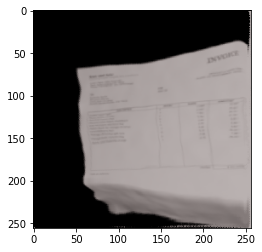

In [22]:
plt.imshow(unwarped_img.detach().numpy()[0])

In [19]:

import pytorch_lightning as pl
from models.backwardmapper import Backwardmapper
#from models.densenetccnl import dnetccnl
from models.full_model import crease
DATA_PATH = 'Dataset Preview/Inv3D preview complete V2/data/'
data_dir= 'Dataset Preview/Inv3D preview complete V2/data/train/'


from custom_dataset import CustomImageDataset_wc, Dataset_backward_mapping, Dataset_full_model
dataset_train = CustomImageDataset_wc(data_dir=DATA_PATH+'train/', transform=True)
dataset_val = CustomImageDataset_wc(data_dir=DATA_PATH+'val/', transform=True)
dataset_test = CustomImageDataset_wc(data_dir=DATA_PATH+'test/', transform=True)
train_dataset_bm = Dataset_backward_mapping(data_dir=DATA_PATH+'train/')
train_full_model = Dataset_full_model(data_dir=DATA_PATH+'train/')


from torch.utils.data import DataLoader
train_loader_bm = DataLoader(train_dataset_bm, batch_size=2, num_workers=8, shuffle=True)

train_loader = DataLoader(dataset_train, batch_size= 1, num_workers=12)
val_loader = DataLoader(dataset_val, batch_size= 1, num_workers=12)
test_loader = DataLoader(dataset_test, batch_size= 1, num_workers=12)

train_loader_full = DataLoader(train_full_model, batch_size=2, num_workers=8, shuffle=True)

from models import unetnc
model = unetnc.Estimator3d(input_nc=3, output_nc=8, num_downs=5)
model_bm = Backwardmapper()
#model_dnet = dnetccnl(in_channels=3)

crease_model = crease(use_pre_trained=True)
#8 channel


# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(gpus=8) (if you have GPUs) 


trainer = pl.Trainer(gpus=1, max_epochs = 500)



#trainer = pl.Trainer(auto_select_gpus = True, max_epochs = 100)
#trainer.fit(model, train_loader)

# Wie sieht der Batch aus, der vom trainer und train_loader generiert wird?

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [2]:
#trainer.fit(model_bm, train_loader_bm)
#trainer.fit(model, train_loader)
trainer.fit(crease, train_loader_full)
#CustomImageDataset_wc.calculate_min_and_max(data_dir)


/home/leon/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type           | Params
----------------------------------------------------------
0 | estimator3d            | Estimator3d    | 16.7 M
1 | backward_map_estimator | Backwardmapper | 45.8 M
----------------------------------------------------------
62.5 M    Trainable params
0         Non-trainable params
62.5 M    Total params
249.901   Total estimated model params size (MB)
Epoch 499: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s, loss=0.292, v_num=69]


In [12]:
for batch in train_loader_full:
   images, labels = batch

In [5]:
!tensorboard --logdir ./lightning_logs

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [10]:
model_bm.test_forward(images)

RuntimeError: Expected tensor to have CPU Backend, but got tensor with CUDA Backend (while checking arguments for batch_norm_cpu)

In [9]:
images.shape

torch.Size([2, 3, 256, 256])

## Angles test

In [8]:
import angles
import torch
import numpy as np

data_path = 'Dataset Preview/Inv3D preview complete V2/data/train/08'

def transform_labels(labels):
    for label in labels:

        lbl = labels[label]
        lbl = lbl.transpose(2, 0, 1)   # NHWC -> NCHW
        lbl = np.array(lbl, dtype=np.float64)
        lbl = torch.from_numpy(lbl).float()
        lbl = lbl.unsqueeze(0)
        labels[label] = lbl

    return labels


labels = {}
labels['warped_bm'] = np.load(data_path + '/warped_BM.npz')['warped_BM']
labels['warped_uv'] = np.load(data_path + '/warped_UV.npz')['warped_UV']
labels['warped_angle'] = np.load(data_path + '/warped_angle.npz')['warped_angle']
labels = transform_labels(labels)

#angles_map = angles.calc_angles_torch(labels['warped_bm'].transpose(1,2).transpose(2,3))
#warped_angle = angles.warp_grid_torch(angles_map, labels['warped_uv'].transpose(1,2).transpose(2,3)).transpose(3,2).transpose(2,1)

In [10]:
model_bm.eval()
decoded = model_bm(images)

In [11]:
decoded.shape

torch.Size([1, 2, 256, 256])

In [18]:
import math
def l_angle_def(theta_x, theta_y, theta_x_gt, theta_y_gt , type = 'paper'):
    if type == 'paper':
        l_x = (torch.abs(torch.sub(theta_x, theta_x_gt)) - math.pi) % (2*math.pi)
        l_y = (torch.abs(torch.sub(theta_y, theta_y_gt)) - math.pi) % (2*math.pi)
        l_angle = torch.add(l_x, l_y)
        return l_angle
    else:
        l_x = (math.pi) - torch.abs((torch.abs(torch.sub(theta_x, theta_x_gt)) - math.pi))
        l_y = (math.pi) - torch.abs((torch.abs(torch.sub(theta_y, theta_y_gt)) - math.pi))
        l_angle = torch.add(l_x, l_y)
        return l_angle
l1_loss = torch.norm((decoded - labels['warped_bm']),p=1,dim=(1))
# angle loss noch
print(decoded.shape)
angles_map = angles.calc_angles_torch(decoded.transpose(1,2).transpose(2,3))
print(angles_map.shape)
warped_angle = angles.warp_grid_torch(angles_map, labels['warped_uv'].transpose(1,2).transpose(2,3))
warped_angle = warped_angle.transpose(3,2).transpose(2,1)
print(warped_angle.shape)
theta_x = warped_angle[:,0:1,:,:]
theta_y = warped_angle[:,1:2,:,:]
print(theta_x.shape)

theta_x_gt = labels['warped_angle'][:,0:1,:,:]
theta_y_gt = labels['warped_angle'][:,1:2,:,:]
l_angle = l_angle_def(theta_x, theta_y, theta_x_gt, theta_y_gt, 'test')
l_angle = l_angle * labels['warped_text_mask']

torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 1, 256, 256])


KeyError: 'warped_text_mask'